# FDA Drug Product Data

FDA provides a database for searching all the published drugs and all the unpublished drugs on their website, This database provides all the information about package of drugs and compositions of drugs their NDC codes. 

Drugs_product (current and unfinished)

- PRODUCTID - Id of the product
- PRODUCTNDC - National drug code of the product
- PRODUCTTYPENAME - Type of the product 
- PROPRIETARYNAME - Proprietary name of the product
- PROPRIETARYNAMESUFFIX - Proprietary name Suffix
- NONPROPRIETARYNAME - Non- proprietary (common name) of the product
- DOSAGEFORMNAME - Dosage information
- ROUTENAME - Route of taking drugs (Oral / Injections)
- STARTMARKETINGDATE - Date on which marketing for the drug has started
- ENDMARKETINGDATE - Date on which the marketing for the drug has stopped
- MARKETINGCATEGORYNAME - Marketing category name
- APPLICATIONNUMBER - Application number for registering drug
- LABELERNAME - Labeler name
- SUBSTANCENAME - Names of the substances in drug
- ACTIVE_NUMERATOR_STRENGTH - Strength of the drug
- ACTIVE_INGRED_UNIT - Unit of strength
- PHARM_CLASSES - Pharmaceutical class of the drugs
- DEASCHEDULE - DEA schedule

source: https://www.kaggle.com/datasets/maheshdadhich/us-healthcare-data?datasetId=7684&sortBy=dateRun&tab=profile

## What makes this dataset interesting?

This dataset is interesting for couple of its intriguing characteristics, namely, 

1) **ALL the features of this dataset are categorical**. That is, there are no numerical values in this dataset and all the features have data type "object". This is a challenging for the follwing reason:

  - Some of these features have **large cardinalities**. Meaning, these featues have several thousands of unique values. We will have to choose feature encoding methods wisely and carefully to avoid/circumvent the problem of "curse of dimensionality".

  Feature encoding (converting categorical features into numeric values), by construction, creates extra features in our dataset. These extra features are dependent on and are proportional to the number of categories or unique values within the feature. This is not a problem when the number of categories in a feature is small. However, when the number of caterories (or unique values) gets larger (aka for features with large cardinality), the extra features created via feature encoding will become too much for the model to handle. This will greatly slow down computation time. This is situation is often referred to as "curse of dimensionality". 
  
 - **Correlations**
    Computing correlations between categorical features cannot be done by the usual method of chi2 calculation. The mathematical/statistical method implemented here will be **Cramer's V rule**. We will be using an a new library called **Dython** and the function **associations** within dython to calculate the correlation matrix between catergorical variables. More details in the section under correlations.

2) This is a **large dataset** with about 118,000 data points (rows)!

## Objective : Drug Classification

The **objective of this project is to classify any given drug into one of the following categories**

- OTC (over the counter)
- Prescription
- Allergenic 

or 

- Other

This is a **classification problem** and we shall implement several different types of classification models to make the above prediction. 

## Outline

1) EDA (exploratory data analysis) 

2) Feature Enginerring

3) Feature Encoding

4) Supervised Learning for Classification

5) Error comparisons

6) Final Remarks and Scope


# Getting Started

In [162]:
import pandas as pd
import numpy as np, os

from matplotlib.pyplot import figure
from sklearn.utils import shuffle

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import plotly.express as px

import category_encoders as ce

from sklearn.preprocessing import OneHotEncoder, LabelEncoder

from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.model_selection import train_test_split, learning_curve

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, BaggingClassifier

from sklearn.feature_selection import SelectFromModel

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV

from sklearn import metrics
from sklearn.metrics import classification_report, precision_recall_fscore_support 
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay 
from sklearn.metrics import make_scorer, fbeta_score

from sklearn.inspection import permutation_importance

from collections import Counter

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from  io import StringIO
import pydotplus
import matplotlib.image as mpimg

from dython.nominal import associations
from dython.nominal import identify_nominal_columns


from tqdm import tqdm

In [6]:
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

In [7]:
data = pd.read_csv('Drugs_product.csv',encoding='latin1')

In [10]:
#data.head().T

Let's begin by looking at the list of features, the number of non-null values for each of these features and their respective data types.

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 117365 entries, 0 to 117364
Data columns (total 18 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   PRODUCTID                  117365 non-null  object 
 1   PRODUCTNDC                 117365 non-null  object 
 2   PRODUCTTYPENAME            117365 non-null  object 
 3   PROPRIETARYNAME            117360 non-null  object 
 4   PROPRIETARYNAMESUFFIX      17109 non-null   object 
 5   NONPROPRIETARYNAME         117355 non-null  object 
 6   DOSAGEFORMNAME             117365 non-null  object 
 7   ROUTENAME                  115284 non-null  object 
 8   STARTMARKETINGDATE         117360 non-null  float64
 9   ENDMARKETINGDATE           2305 non-null    float64
 10  MARKETINGCATEGORYNAME      117365 non-null  object 
 11  APPLICATIONNUMBER          101669 non-null  object 
 12  LABELERNAME                117365 non-null  object 
 13  SUBSTANCENAME              11

**Size of the dataset**

In [11]:
row,col = data.shape

print('The number of rows in the dataset = ', row)
print('The number of columns in the dataset = ', col,'\n')

The number of rows in the dataset =  117365
The number of columns in the dataset =  18 



# EDA (exploratory data analysis)

The goal in this section is twofold:

- to understand the characteristics of the various features (columns) in our dataset 
- to determine which columns we need to keep and which ones we can drop  

We will look like **null values, unique values and correlations** between the various features to identify the columns that need to be dropped. 

## Null & Unique values 

A look at the **null values** will help us determine which part of our dataset we can drop. Do we drop specific rows or a specific column? 

The total number of **unique values** will help illuminate the purpose and the nature of the column. 
For example, a column that contains an ID for each row will likely have many unique values and in most cases as many unique values as the total number of rows (or data points). Such columns are not useful because they don't provide any new insight into the data. Such columns, therefore, can safely be removed from further data analysis. 
On the other hand, columns with fewer unique values are usually important because they tend to classify the data into a finite set of groups or categories. 

A look at the total unique values within a column, therefore, is very useful.. especially if the dataset has many features/columns. 

The following is a table of total null vales and the total number of unqiue values for each of our features.

In [12]:
data_null = data.isnull().sum().rename_axis('Cols').reset_index(name='No_null_vals')
#data_null

In [13]:
data_unq = data.nunique().rename_axis('Cols').reset_index(name='No_unique_vals')
#data_unq

In [14]:
data_null_unq = pd.concat([data_null, data_unq], axis=1)
data_null_unq = data_null_unq.T.drop_duplicates().T
data_null_unq

,Cols,No_null_vals,No_unique_vals
0,PRODUCTID,0,117365
1,PRODUCTNDC,0,115678
2,PRODUCTTYPENAME,0,7
3,PROPRIETARYNAME,5,43729
4,PROPRIETARYNAMESUFFIX,100256,7277
5,NONPROPRIETARYNAME,10,20572
6,DOSAGEFORMNAME,0,136
7,ROUTENAME,2081,200
8,STARTMARKETINGDATE,5,7825
9,ENDMARKETINGDATE,115060,619


The table above encapsulates the information about the total number of null values and the total unique values for each column. The decision to drop specific rows or columns is based on the following factors:

- Usefulness of the said row or column .. ie .. Does this data add any new insight to the dataset.
- Will removing the data influence/restrict/constrain the dataset and analysis that follows? If so, we need to keep such data and not drop it. 


**To Drop**

- The first set of columns that can immediately be removed from our dataset since they have nearly as many unique values (>100k) as the total datapoints (117k) in the dataset. 

    - PRODUCTID
    - PRODUCTNDC

- The next set of columns that can be dropped are the following. There are dropped due to two reasons- they have a large number of null values **and** the unique values in these columns provide no new information towards our classification question - product type classification (OTC, precription or other).

    - DEASCHEDULE
    - ENDMARKETINGDATE
    - PROPRIETARYNAMESUFFIX
    - APPLICATIONNUMBER

- Finally, we will also drop the columns - "PHARM_CLASSES" and "ACTIVE_INGRED_UNIT" .

    PHARM_CLASSES : Nearly half of the total data in this column is null. Removing just the null values and keeping this column will result of loss of almost half the total datapoints (rows). Therefore, the best way to handle the large number of nan values (>50k) in this column is to do away with this entire column. 

    ACTIVE_INGRED_UNIT : As shown below, provides the scientific units for each of the ingredients that make up the drug. This information by itself does not lend any new or specific insight that might influenvce or help classify the data. This column can also be removed from further analysis.

In [15]:
data.ACTIVE_INGRED_UNIT.head()

0     mCi/mL
1      mg/mL
2    mg/.5mL
3    mg/.5mL
4      mg/mL
Name: ACTIVE_INGRED_UNIT, dtype: object

In [16]:
data = data.drop(['PRODUCTNDC','PRODUCTID',
           'PROPRIETARYNAMESUFFIX', 
           'ENDMARKETINGDATE', 
           'DEASCHEDULE',
           'APPLICATIONNUMBER',
           'PHARM_CLASSES',
            'ACTIVE_INGRED_UNIT'],
          axis=1)



In [17]:
# Dropping all rows that contain NAN values
data = data.dropna()

**Final list of null values and unique values per column**

In [18]:
data_null_dr = data.isnull().sum().rename_axis('Cols').reset_index(name='No_null_vals')
data_unq_dr = data.nunique().rename_axis('Cols').reset_index(name='No_unique_vals')

data_null_unq_dr = pd.concat([data_null_dr, data_unq_dr], axis=1)
data_null_unq_dr = data_null_unq_dr.T.drop_duplicates().T
data_null_unq_dr

,Cols,No_null_vals,No_unique_vals
0,PRODUCTTYPENAME,0,7
1,PROPRIETARYNAME,0,42298
2,NONPROPRIETARYNAME,0,19923
3,DOSAGEFORMNAME,0,134
4,ROUTENAME,0,173
5,STARTMARKETINGDATE,0,7755
6,MARKETINGCATEGORYNAME,0,13
7,LABELERNAME,0,8164
8,SUBSTANCENAME,0,11464
9,ACTIVE_NUMERATOR_STRENGTH,0,11632


## Column similarity

The dataset is now cleaned of null/nan values. We are now left with 11 columns, some of which have more than 10k unique values. 

All categorical columns need to be converted into numerical values via feature encoding before one implements learning algorithms. Implementing feature encoding by definition, creates many new columns based on the number of unique categories within a column. The exact number of extra columns added will depend on the chosen encoding methods. 

Therefore, an important aspect to keep in mind when dealing with columns with large amount of unique values is to make sure such columns are actually useful for our analysis and are **not redundant**. For example, if two columns are identical, one of them should be removed. 

**Similarity observed at first glance**

At first glance the columns "NONPROPRIETARYNAME" and "SUBSTANCENAME" seem indentical. Given the large number of rows, we need to look deeper to verify our assumption of similarity. In order to this, lets convert the two columns to the same case .. say, lower case. Then we shall remove all white spaces and replace the word "and" with a white space. 

In [19]:
data['SUBSTANCENAME']=data['SUBSTANCENAME'].str.lower()
data['NONPROPRIETARYNAME']=data['NONPROPRIETARYNAME'].str.lower()

In [20]:
tmp = data[['SUBSTANCENAME', 'NONPROPRIETARYNAME']].copy()
#tmp.T.head()

In [21]:
tmp['SUBSTANCENAME']=tmp['SUBSTANCENAME'].str.replace(r'\W', ' ')
tmp['NONPROPRIETARYNAME']=tmp['NONPROPRIETARYNAME'].str.replace(r'\W', ' ')

tmp['SUBSTANCENAME']=tmp['SUBSTANCENAME'].str.replace('and', ' ')
tmp['NONPROPRIETARYNAME']=tmp['NONPROPRIETARYNAME'].str.replace('and', ' ')

tmp['SUBSTANCENAME']=tmp['SUBSTANCENAME'].str.replace(" ", '')
tmp['NONPROPRIETARYNAME']=tmp['NONPROPRIETARYNAME'].str.replace(" ", '')

tmp['SUBSTANCENAME']=tmp['SUBSTANCENAME'].str.replace(";", '')
tmp['NONPROPRIETARYNAME']=tmp['NONPROPRIETARYNAME'].str.replace("; ", '')

tmp['SUBSTANCENAME']=tmp['SUBSTANCENAME'].str.replace("-", '')
tmp['NONPROPRIETARYNAME']=tmp['NONPROPRIETARYNAME'].str.replace("-", '')

tmp['SUBSTANCENAME']=tmp['SUBSTANCENAME'].str.replace(",", '')
tmp['NONPROPRIETARYNAME']=tmp['NONPROPRIETARYNAME'].str.replace(",", '')



In [22]:
tmp.T.iloc[:,:7]

,0,1,2,3,4,5,6
SUBSTANCENAME,florbetapirf18,quinidinegluconate,dulaglutide,dulaglutide,ixekizumab,testosterone,testosterone
NONPROPRIETARYNAME,florbetapirf18,quinidinegluconate,dulaglutide,dulaglutide,ixekizumab,testosterone,testosterone


**Dis-similarity on further investigation**

The above table just gives a snap shot of the entire data within these two columns. To be absolutely sure that these columns are indeed identical, let us explicitly search for **dis**similarities using "!=" condition between these columns. 

In [23]:
tmp[tmp['NONPROPRIETARYNAME']!=tmp['SUBSTANCENAME']]

,SUBSTANCENAME,NONPROPRIETARYNAME
51,pemetrexeddisodiumheptahydrate,pemetrexeddisodium
55,pemetrexeddisodiumheptahydrate,pemetrexeddisodium
79,daclatasvirdihydrochloride,daclatasvir
80,daclatasvirdihydrochloride,daclatasvir
81,daclatasvirdihydrochloride,daclatasvir
...,...,...
117332,zincoxidetitaniumdioxide,titaniumdioxidezincoxide
117333,zincoxidetitaniumdioxide,titaniumdioxidezincoxide
117334,zincoxidetitaniumdioxide,titaniumdioxidezincoxide
117339,zincoxidetitaniumdioxide,titaniumdioxidezincoxide


In [24]:
tmp[tmp['NONPROPRIETARYNAME']!=tmp['SUBSTANCENAME']].shape

(29790, 2)

The above table shows that the two columns, that appeared identical at first glance, are in fact not so. There are **around 30k rows** that make these two columns, "SUBSTANCENAME" and "NONPROPRIETARYNAME", **distinct from one another.**

**Note:**
While the two columns above aren't identical, they are (even to the naked eye) correlated with one another. We will, therefore, quantify this correlation in the next section where we will study the correlations between all the features in our dataset.

**Questions:**
1) Is this difference of 30k rows large enough for us to consider both the columns are necessary for analysis **or** is this difference small enough, given the total 117k rows, so as to treat the two columns are similar and consequently use just one of these columns? 

2) If these two columns turn out to be highly correlated (as expected from first glance), then would it be safe to drop one of these columns?

 
**Answer:**
The purpose of the columns "NONPROPRIETARYNAME" is to provide an additional name to each of the drugs (data) in our dataset. It does not provide any new information to describe the drug beyond an alternate name. Therefore, if we can confirm the strong correlation between "NONPROPRIETARYNAME" and "SUBSTANCENAME", we can safely drop "NONPROPRIETARYNAME" from our dataset, without loss of valuable information.

## Correlations between catergorical columns

The similarity study above shows that while the two columns "SUBSTANCENAME" and "NONPROPRIETARYNAME" are not identical, these two columns are highly correlated! It is therefore, useful to go beyond these two features and look at how all the features in our dataset are correlated. 

All the features in our dataset are categorical. Traditional methods use the mean value (for each feature/column) to complute the correlations between the columns. Such methods cannot be used for columns with categorical variables but one cannot compute a mean value for such columns. 

We will use the library **dython** to compute the correlations between all our categorical features. See (https://blog.knoldus.com/how-to-find-correlation-value-of-categorical-variables/) for implementation of this library.

As a test, we will use the **identify_nominal_columns(dataset)** function (from dython library) to look at all the catergorical features/columns in our dataset. 

In [25]:
categorical_features=identify_nominal_columns(data)
categorical_features

['PRODUCTTYPENAME',
 'PROPRIETARYNAME',
 'NONPROPRIETARYNAME',
 'DOSAGEFORMNAME',
 'ROUTENAME',
 'MARKETINGCATEGORYNAME',
 'LABELERNAME',
 'SUBSTANCENAME',
 'ACTIVE_NUMERATOR_STRENGTH']

### The associations function

To generate the **correlation matrix**, we are going to use the **associations function** of the **dython library.**

**associations** *(dataset, nominal_columns='auto', numerical_columns=None, mark_columns=False, nom_nom_assoc='cramer', num_num_assoc='pearson', bias_correction=True, nan_strategy=_REPLACE, nan_replace_value=_DEFAULT_REPLACE_VALUE, ax=None, figsize=None, annot=True, fmt='.2f', cmap=None, sv_color='silver', cbar=True, vmax=1.0, vmin=None, plot=True, compute_only=False, clustering=False, title=None, filename=None)*


This function calculates the correlation/strength-of-association of features in the data-set with both categorical and continuous features using: 
- Pearson’s R for continuous-continuous cases, 
- Correlation Ratio for categorical-continuous cases, 
- Cramer’s V or Theil’s U for categorical-categorical cases.

We will be using the **Cramer's V (with bias correction)** method to calculate the correlations since all our columns categorical. The bias correction mentioned is implemented through the *bias_correction=True* option in the associations function above. 


In [26]:
#data_corr=associations(data, compute_only=True)["corr"] 

In [27]:
#data_corr.to_csv('data_feature_correlations.csv')
#data_corr

<Axes: ylabel='Feature Correlations'>

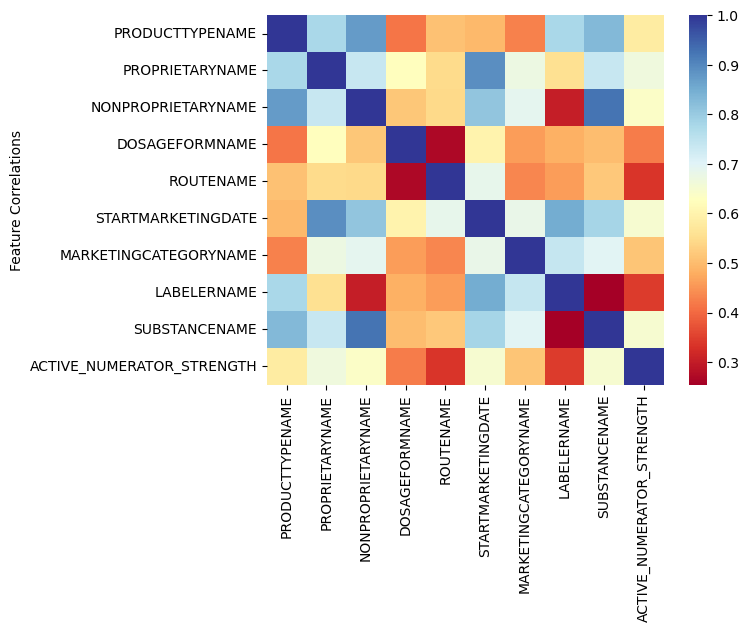

In [28]:
# We ran the code the first time and saved the correlation matrix into a .csv file. 
# Computing  the correlation matrix for a dataset as large as ours takes a lot of time.
# We will read in the correlation matrix for future analysis to save time.

feature_corr = pd.read_csv('data_feature_correlations.csv',encoding='latin1')
feature_corr=feature_corr.rename(columns={"Unnamed: 0": "Feature Correlations"}).set_index('Feature Correlations')
feature_corr_float = feature_corr.astype(float)
sns.heatmap(feature_corr_float, cmap='RdYlBu')

### To drop or not to drop? (again!)

As is evident from the correlation matrix and the heatmap above, the following features are highly correlated, where the correlation coefficient > 0.6

- PROPRIETARYNAME
- NONPROPRIETARYNAME
- STARTMARKETINGDATE
- LABELERNAME
- SUBSTANCENAME

We are, therefore, faced with the **questions**

1) do we drop (some) these highly correlated features?
   
   We can certainly **drop "NONPROPRIETARYNAME"** for reasons mentioned in the earlier section.
   
2) implement some sort of dimensional reduction or feature engineering method that takes care of these correlated features?
   
   Yes. We can **declutter the column "STARTMARKETINGDATE"**. This column contain the date in the form on yyyymmdd.
   The useful information, here, is the year. The actual month and date the drug was manufactured in is not relevant to predict if the drug is OTC, precription or allegenic. Under the section "feature engineering" we will extract just the year from this column and see how just the year is correlated with the rest of the features.
   
3) are there classification models that are not affected by correlated features like tree-models? (https://medium.com/data-design/ensembles-of-tree-based-models-why-correlated-features-do-not-trip-them-and-why-na-matters-7658f4752e1b)



# Feature Engineering

As mentioned earlier, the features in our dataset have a large number of unique values. This is cumbersome because when we transform these features into numberic values via feature encoding, we will end up with an n-fold increase in features depending on the choice of encoding implemented. In order to reduce this n-fold increasing from encoding, we must ensure that the unique values in the feature are truly unique and do not have any redundencies. The redundencies or commonalities within the unique values in column can be handled by re-grouping them under a larger group. 

The goal of this section is the following:

1. **reduce the number of unique values** in the columns without throwing away any data and without losing useful information. 

    THis will be done via the following proces:
    
    - Identify the similarities or redundencies between the unique values
    - Re-classify/group these similar values under a larger group (while take care that no useful information is lost).
    
2. implement **feature encoding**

    Given that the unique values in our final set of features range from a hundreds to tens of thousands, we need to choose the feature encoding wisely. More about this in the encoding subsection.



In [29]:
# Save a copy of the cleaned up data
df = data.copy()
dtcopy= data.copy()

In [30]:
df=df.rename(columns={'PRODUCTTYPENAME': 'Target', 
                      'PROPRIETARYNAME': 'Propriety Name',
                      'MARKETINGCATEGORYNAME': 'Marketing Name',
                      'LABELERNAME': 'Labeler Name',
                      'SUBSTANCENAME': "Substance Name",
                      'ACTIVE_NUMERATOR_STRENGTH': "Strength",
                      'ACTIVE_INGRED_UNIT':'Active Ingredient Unit',
                      'DOSAGEFORMNAME': 'Doseage Form Name',
                      'ROUTENAME': 'Route Name',
                      'NONPROPRIETARYNAME' : 'NonPropriety Name',
                      'STARTMARKETINGDATE' : 'Start Marketing Date'})

## Reduce the number unique values via Re-Grouping

Our goal, here, is to try and bring down the number of unique values as a small a number as possible withOUT losing any useful information. 


In [31]:
#df.nunique()

**Features that have less than 200 unique values.** 

In [32]:
df.loc[:,df.nunique()<200].nunique()

Target                 7
Doseage Form Name    134
Route Name           173
Marketing Name        13
dtype: int64

We will focus on the four above features. In order to determine how we can re-group the unique values in these featues, we first need to understand the weight of each of these values. How are all these unique values distributed? 

### TARGET 

**This is our Target feature (our "y" variable for when we implement learning models into our dataset).** We will use this column to teach our model how to predict the outcome .. ie .. how to classify the a given drug.

The following table shows the relative frequency (or distribution) of the unique values within our column and is denoted by "count".

In [33]:
df.Target.value_counts(normalize=True).rename_axis('Target').reset_index(name='Count')


,Target,Count
0,HUMAN OTC DRUG,0.518589
1,HUMAN PRESCRIPTION DRUG,0.464377
2,NON-STANDARDIZED ALLERGENIC,0.014605
3,STANDARDIZED ALLERGENIC,0.000845
4,PLASMA DERIVATIVE,0.000784
5,VACCINE,0.000758
6,CELLULAR THERAPY,0.000044


As is evident from the above table, the following categories make up over 90% of all other categories combined 

- HUMAN OTC DRUG
- HUMAN PRESCRIPTION DRUG 

We can also combine the following into a single category called "Allergenic"

- NON-STANDARDIZED ALLERGENIC
- STANDARDIZED ALLERGENIC 

 and mark the rest as "Others"

- PLASMA DERIVATIVE
- VACCINE
- CELLULAR THERAPY




In [34]:
string = ['NON-STANDARDIZED ALLERGENIC', 'STANDARDIZED ALLERGENIC']

for st in string:
    df['Target'] = np.where(df['Target']==st, 'Allergenic', df['Target'])
    

string = ['PLASMA DERIVATIVE', 'VACCINE', 'CELLULAR THERAPY']

for st in string:
    df['Target'] = np.where(df['Target']==st, 'Others', df['Target'])
    

**Relative Frequency Table (after re-grouping)**

In [35]:
df.Target.value_counts(normalize=True).rename_axis('Target').reset_index(name='Count')

,Target,Count
0,HUMAN OTC DRUG,0.518589
1,HUMAN PRESCRIPTION DRUG,0.464377
2,Allergenic,0.015449
3,Others,0.001585


We have now reduced the total number of unique values from 7 down to 4 without any loss of relevant information. Here is a visual display of the table above.

<Axes: >

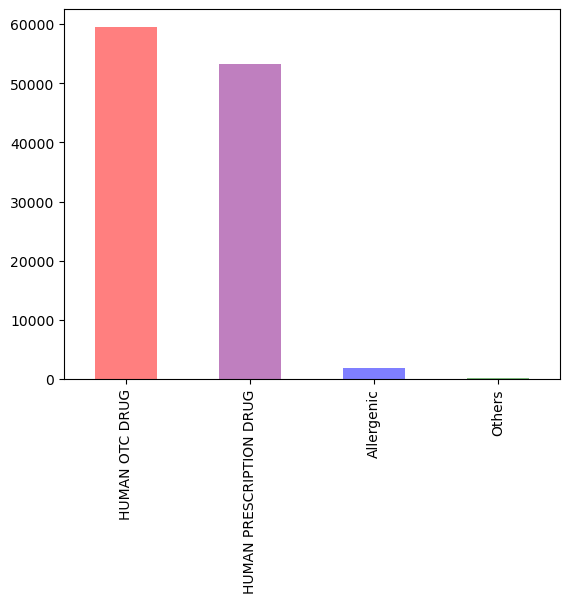

In [36]:
df.Target.value_counts(normalize=False).plot.bar(color=['Red','Purple', 'Blue', 'Green'], alpha=0.5)

### Marketing Name

In [37]:
#df['Marketing Name'].nunique()

As before, here's the table with the relative frequency of each unique value within this column.

In [38]:
tmp=df['Marketing Name'].value_counts(normalize=True).rename_axis('Marketing_Name').reset_index(name='Count')
tmp#[tmp['Count']>0.001]

,Marketing_Name,Count
0,ANDA,0.351546
1,OTC MONOGRAPH NOT FINAL,0.188118
2,OTC MONOGRAPH FINAL,0.180202
3,UNAPPROVED HOMEOPATHIC,0.094516
4,NDA,0.083108
5,BLA,0.050241
6,UNAPPROVED DRUG OTHER,0.032527
7,NDA AUTHORIZED GENERIC,0.012375
8,UNAPPROVED MEDICAL GAS,0.007054
9,UNAPPROVED DRUG FOR USE IN DRUG SHORTAGE,0.000200


Based on the information in the table above, we shall group the categories as follows:

1. BLA and Others
    - BLA
    - PREMARKET NOTIFICATION
    - IND

2. NDA Types
    - NDA
    - NDA AUTHORIZED GENERIC
    
3. UNAPPROVED 
    - UNAPPROVED HOMEOPATHIC
    - UNAPPROVED DRUG OTHER
    - UNAPPROVED DRUG FOR USE IN DRUG SHORTAGE
    - UNAPPROVED OTHER

In [39]:
string = ['NDA','NDA AUTHORIZED GENERIC']

for st in string:
    df['Marketing Name'] = np.where(df['Marketing Name']==st, 'NDA Types', df['Marketing Name'])

    
string = ['UNAPPROVED HOMEOPATHIC',
          'UNAPPROVED DRUG OTHER',
          'UNAPPROVED DRUG FOR USE IN DRUG SHORTAGE', 
          'UNAPPROVED OTHER',
          'UNAPPROVED MEDICAL GAS']

for st in string:
    df['Marketing Name'] = np.where(df['Marketing Name']==st, 'UNAPPROVED', df['Marketing Name'])

    

string = ['BLA','PREMARKET NOTIFICATION','IND']

for st in string:
    df['Marketing Name'] = np.where(df['Marketing Name']==st, 'BLA and Others', df['Marketing Name'])
    


**Relative Frequency Table (after re-grouping)**

In [40]:
df['Marketing Name'].value_counts(normalize=True)

ANDA                       0.351546
OTC MONOGRAPH NOT FINAL    0.188118
OTC MONOGRAPH FINAL        0.180202
UNAPPROVED                 0.134341
NDA Types                  0.095483
BLA and Others             0.050310
Name: Marketing Name, dtype: float64

<Axes: >

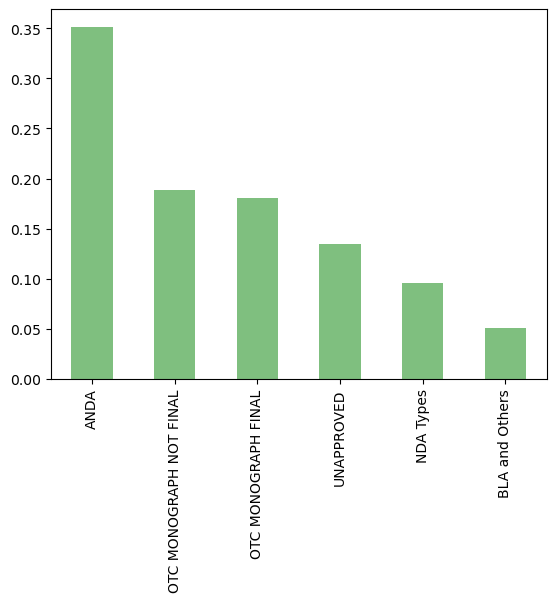

In [41]:
df['Marketing Name'].value_counts(normalize=True).plot.bar(color='Green', alpha=0.5)

We have now reduced the total unique values in this feature from 13 down to 6!

### Doseage Form Name 
This feature denotes the form/type of drug. Tablet, Solution, Injection etc. 

The total number of unique values in this column is

In [42]:
df['Doseage Form Name'].nunique()

134

Here's a snapshot of the type catergories present in this column. This will help is understand how to re-group the categories. 

In [43]:
tmp = df['Doseage Form Name'].value_counts(normalize=True).rename_axis('Dosage Form Name').reset_index(name='Count')
tmp[tmp['Count']>0.012]

,Dosage Form Name,Count
0,TABLET,0.173200
1,LIQUID,0.102850
2,"TABLET, FILM COATED",0.090545
3,CREAM,0.069069
4,"INJECTION, SOLUTION",0.067353
5,CAPSULE,0.046757
6,GEL,0.036403
7,LOTION,0.031578
8,SOLUTION,0.031151
9,PELLET,0.026762


In [44]:
#injection = data[(data['DOSAGEFORMNAME']=='INJECTION, SOLUTION')|(data['DOSAGEFORMNAME']=='INJECTION')]

In [45]:
#injection.shape

In [46]:
string = ['TABLET', 'INJECTION', 'LIQUID', 'CAPSULE', 'CREAM', 'SOLUTION',
          'OINTMENT', 'POWDER', 'SUSPENSION', 'GRANULE', 
          'LOTION','PATCH', 'PASTE', 'GEL', 'AEROSOL', 'GUM',
          'SPRAY']

for st in string:
    df['Doseage Form Name']=np.where(df['Doseage Form Name'].str.contains(st), 
                                   st+' types', 
                                   df['Doseage Form Name'])
    
df['Doseage Form Name'] = np.where(~df['Doseage Form Name'].str.contains('types'), 'Misc', df['Doseage Form Name'])


In [47]:
mode_norm = df['Doseage Form Name'].value_counts(normalize=True).rename_axis('Dosage Form Name').reset_index(name='Count')
mode_count = df['Doseage Form Name'].value_counts(normalize=False).rename_axis('Dosage Form Name').reset_index(name='Count')

In [48]:
#mode_count[mode_count['Count']>1000]

**Relative Frequency Table (after re-grouping)**

In [49]:
mode_norm#[mode_norm['Count']>0.01]

,Dosage Form Name,Count
0,TABLET types,0.327658
1,LIQUID types,0.115417
2,Misc,0.114520
3,INJECTION types,0.095622
4,CREAM types,0.069156
5,CAPSULE types,0.066726
6,SOLUTION types,0.044449
7,GEL types,0.038336
8,LOTION types,0.032414
9,SPRAY types,0.019473


<Axes: >

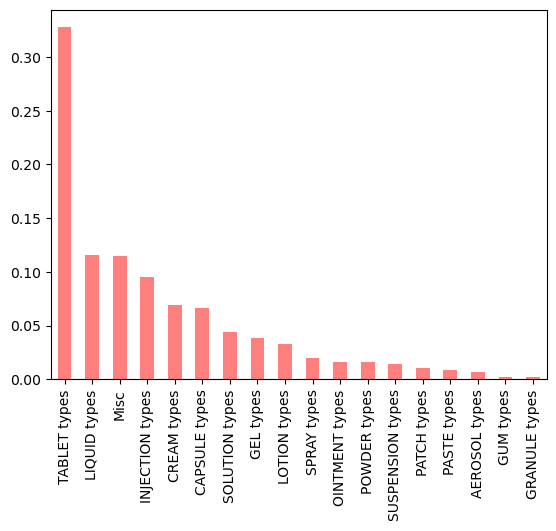

In [50]:
df['Doseage Form Name'].value_counts(normalize=True).plot.bar(color='Red', alpha=0.5)

We have now reduced the total unique values in this feature from 134 down to 18!

### Route Name

This column denotes the method by which the drug can be consumed. For example, oral, intravenous, etc ..

In [51]:
df['Route Name'].value_counts(normalize=True).rename_axis('Route Name').reset_index(name='Count')[:18]

,Route Name,Count
0,ORAL,0.546065
1,TOPICAL,0.287816
2,INTRADERMAL; SUBCUTANEOUS,0.028417
3,INTRAVENOUS,0.027642
4,DENTAL,0.012715
5,RESPIRATORY (INHALATION),0.012619
6,OPHTHALMIC,0.011156
7,SUBCUTANEOUS,0.009954
8,INTRAMUSCULAR; INTRAVENOUS,0.008657
9,NASAL,0.005504


In [52]:
string=['ORAL', 'TOPICAL', 'DENTAL', 'NASAL','SUBCUTANEOUS', 'INTRA']

for st in string:
    df['Route Name']=np.where(df['Route Name'].str.contains(st), 
                                   st+' etc', 
                                   df['Route Name'])
    


In [53]:
df['Route Name'] = np.where(~df['Route Name'].str.contains('etc'), 'Others', df['Route Name'])


**Relative Frequency Table (after re-grouping)**

In [54]:
tmp=df['Route Name'].value_counts(normalize=True).rename_axis('Route').reset_index(name='Count')
tmp#[tmp['Count']>=0.01]

,Route,Count
0,ORAL etc,0.549252
1,TOPICAL etc,0.288739
2,Others,0.050450
3,SUBCUTANEOUS etc,0.048029
4,INTRA etc,0.045225
5,DENTAL etc,0.012767
6,NASAL etc,0.005539


<Axes: >

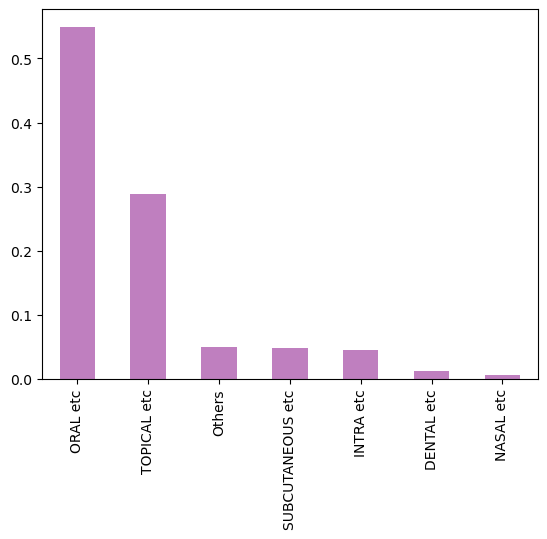

In [55]:
df['Route Name'].value_counts(normalize=True).plot.bar(color='Purple', alpha=0.5)

We have now reduced the total unique values in this feature from 173 down to 7!

## Features with Large Cardinality

- Propriety Name 
- NonPropriety Name  
- Start Marketing Date 
- Labeler Name  
- Substance Name
- Strength

These are the feature will very large cardinality, meaning, these features have extremely large number of unique values. Some of these features are also highly correlated (as observed in section 3 under correlations). 

We have to use fair judgement on which of these features are truly necessary for our analysis. The following is the list of features (with high cardinality) we will use:

- Propriety Name : **Keep** 

    This feature provides the name of each drug. We need this feature because we will ultimately be classifying a drug into a specific category given its name.  
    
- NonPropriety Name : **Drop**

    This feature isn't useful since we already have the propriety name. We will drop this feature.

- Start Marketing Date : **Keep**

    This is useful and we will keep this. 
    
- Labeler Name : **Keep**  

    This feature marks the labs the drugs were made it. Useful information. Keep. 
    
- Substance Name : **Keep**

    This feature described the substances used to make the drug. Useful. Keep.
    
- Strength : **Drop**

    This feature contains the strength of the substances used to make the drug. This isn't going add any new information to our analysis. We will drop this feature.

**List of features to be used from our main dataset**

In [56]:
df=df.drop(['NonPropriety Name','Strength'], axis=1)

In [57]:
df.nunique().rename_axis('Features').reset_index(name='No. of Unique Values')

,Features,No. of Unique Values
0,Target,4
1,Propriety Name,42298
2,Doseage Form Name,18
3,Route Name,7
4,Start Marketing Date,7755
5,Marketing Name,6
6,Labeler Name,8164
7,Substance Name,11464


### Start Marketing Date

This feature contains information about the Marketing Start Date which is given in the format : yyyymmdd. 

Note this feature has data type "object", despite have numeric values.

The number of unique values in this feature is:

In [58]:
df['Start Marketing Date'].nunique()

7755

Before we attempt to reduce the number of unique values, we shall first separate out the year, month and date into three separate columns, namely,

- Start Marketing Year
- Start Marketing Month
- Start Marketing Day


In [59]:
df['Start Marketing Year'] = df['Start Marketing Date'].astype(str).str[:4]
df['Start Marketing Month'] = df['Start Marketing Date'].astype(str).str[4:6]
df['Start Marketing Day'] = df['Start Marketing Date'].astype(str).str[6:8]

#### Start Marketing Year

As before, let's beging by looking at the relative frequencies of the unique values within our new column "Start Marketing Year".

In [60]:
tmp=df['Start Marketing Year'].value_counts(normalize=True).rename_axis('Start Marketing Year').reset_index(name='Count')
tmp#[tmp['Count']>0.001]

,Start Marketing Year,Count
0,2015,0.100577
1,2014,0.091616
2,2016,0.090676
3,2013,0.080774
4,2012,0.075688
...,...,...
85,1930,0.000009
86,1943,0.000009
87,1907,0.000009
88,1929,0.000009


The table above shows that we have data from year 1905 to as recently as 2015. As is evident, the act of sepatarting out the date into seaprate columns of year, month and date, reduced the number of unique values from over 7000 down to 90 (just looking at the year)! We can reduce the unique values even further by clubbing each decade as a single category. 

To do this efficiently, we will first convert the data type of this column from object to int64. 

In [61]:
df['Start Marketing Year']=df['Start Marketing Year'].astype(int)

In [62]:
df['Start Marketing Year'].dtype

dtype('int64')

Then, for the period ranging from 1900 until 2020, we will re-group this column into separate decades. 

For example 1900-1910 will be one decade, labelled by the start year of the decade- 1900 in this example. 
1910-1920 will be another decade labelled as 1910, 
1920-1930 will be labelled as 1920 and so on ..


In [63]:
for i in range(1900,2020,10):
    
    df['Start Marketing Year'] = np.where((df['Start Marketing Year']>=i) & (df['Start Marketing Year']<i+10), 
                                       i, 
                                       df['Start Marketing Year'])

In [64]:
df['Start Marketing Year'].value_counts(normalize=True).rename_axis('Decade Start Year').reset_index(name='Count')

,Decade Start Year,Count
0,2010,0.652521
1,2000,0.205979
2,1990,0.064541
3,1970,0.035166
4,1980,0.023296
5,1960,0.012096
6,1940,0.003414
7,1950,0.002203
8,1930,0.000592
9,1900,0.000087


**Viola! We've now shrunk the unique values down to 12 :)**

The above table shows that the majority of the data correposnds to years after the turn of the new century .. ie .. in the 2000s. 

<Axes: >

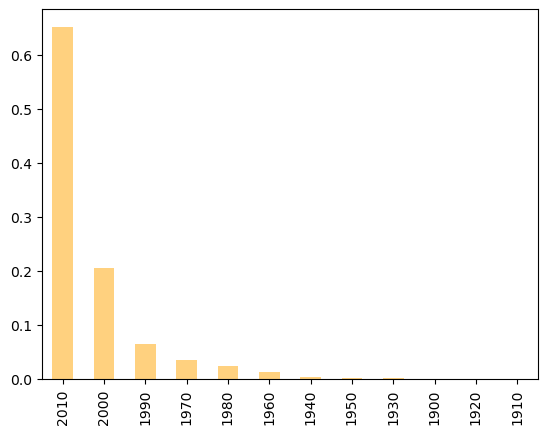

In [65]:
df['Start Marketing Year'].value_counts(normalize=True).plot.bar(color='Orange', alpha=0.5)

The plot above clearly indicates that (as also evident in the table above) that data for years prior to 1960 have very little influence on the overall dataset. We can, therefore, club the decades prior to 1960 into a single category as "1900 to 1960". 

In [66]:
for i in range(1900,1960,10):
    
    df['Start Marketing Year'] = np.where((df['Start Marketing Year']>=i) & (df['Start Marketing Year']<i+10), 
                                       1900, 
                                       df['Start Marketing Year'])

We shall now convert the data type of column back to an object so that we can label the categories as a string. 

In [67]:
df['Start Marketing Year']=df['Start Marketing Year'].astype(str)
df['Start Marketing Year'] = np.where((df['Start Marketing Year']=='1900'), 
                                       '1900 to 1960', 
                                       df['Start Marketing Year'])

<Axes: >

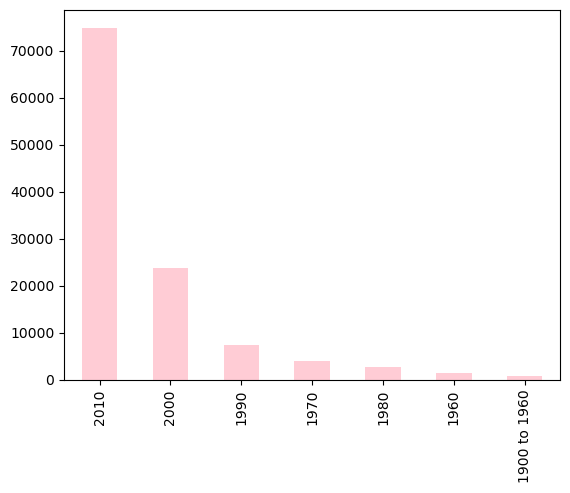

In [68]:
df['Start Marketing Year'].value_counts().plot.bar(color='Pink', alpha=0.8)

We will now rename this column more appropriately to "Marketing Decade Start Year"

In [69]:
df.rename(columns={'Start Marketing Year': 'Marketing Decade Start Year'}, inplace=True)

In [70]:
#df.dtypes

#### Start Marketing Month & Start Marketing Day

In [71]:
#tmp_mon = df['Start Marketing Month'].value_counts(normalize=True).rename_axis('Start Marketing Month').reset_index(name='Count')
#tmp_day = df['Start Marketing Day'].value_counts(normalize=True).rename_axis('Start Marketing Day').reset_index(name='Count')

In the above subsection, we re-grouped the information in the feature 'Start Marketing Date' into separate decades, ranging from 1900 upto 2020. This means that each data point (drug) is associated now with a specific decade. With this in mind, it knowing the actual month and day the drugs were marketed because meaningless. 

We can, therefore, **drop the columns for Month and Day**.

In [72]:
df=df.drop(['Start Marketing Month', 'Start Marketing Day'], axis=1)

We can, now, also drop the original date column 'Start Marketing Date' since we have already extracted the relevant information from this feature.

In [73]:
df=df.drop(['Start Marketing Date'], axis=1)

In [74]:
dfcopy = df.copy()

### Propriety Name, Labeler Name & Substance Name

In [75]:
tmp=df.nunique().rename_axis("Features").reset_index(name="No. Unique Values")

Feat_highCard = tmp[tmp['No. Unique Values']>1000]
Feat_lowCard = tmp[tmp['No. Unique Values']<1000]

Here's a list of **features with the heighest cardinalities** .. ie .. heightest number of unique values. 

In [76]:
Feat_highCard.sort_values(by=['No. Unique Values'], ascending=False)

,Features,No. Unique Values
1,Propriety Name,42298
6,Substance Name,11464
5,Labeler Name,8164


These features have too many unique values for us to really benefit from re-grouping. We shall, therefore, retain them as is and find an appropriate encoding method that can handle such large cardinalities. 

In [77]:
#ax = sns.countplot(x='Labeler Name',data=dt_high_card).set(xticklabels=[])
#plt.ylim(0, 400)
#plt.show()

## Final (post-processed) Dataset 

Here's the final list of features that we will use to implement our classification models.

In [78]:
df.describe(include='object').T.sort_values(by=['unique'], ascending=False)

,count,unique,top,freq
Propriety Name,114827,42298,Ibuprofen,511
Substance Name,114827,11464,alcohol,2667
Labeler Name,114827,8164,"Nelco Laboratories, Inc.",2362
Doseage Form Name,114827,18,TABLET types,37624
Route Name,114827,7,ORAL etc,63069
Marketing Decade Start Year,114827,7,2010,74927
Marketing Name,114827,6,ANDA,40367
Target,114827,4,HUMAN OTC DRUG,59548


In [79]:
dfin = df.copy()

## Encoding 

We will implement **FOUR different types of encoding** techniques here, namely:

- **Label Encoder** 
    We'll use label encoder for our Target feature. 
  
  
- **Target Encoding**
    Finally, we'll implement Target encoding method to encode the features that have very large cardinality, where the number of unique values is greater than 1000! Each category is encoded based on a shrunk estimate of the average target values for observations belonging to the category. The encoding scheme mixes the global target mean with the target mean conditioned on the value of the category. 
    
    (https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.TargetEncoder.htmlhttps://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.TargetEncoder.html)

    We will implement Target encoding on the following features:
    
    - Propriety Name
    - Labeler Name
    - Substance Name

    since there features have over 8k unique values.
    
- **One-hot Encoding/Dummy Encoding**:
    We will implement this encoding method on the following features.
    
    - RouteName
    - Marketing Name
    - Marketing Decade Start Year
    
    This encoding method will create a new column for each of the unique values for each feature. 
    
- **Binary Encoding**
    We will implement this encoding method on columns that have moderate number of unique categories. The binary encoder will first convert the unique categories into unique numeric labels (1, 2, ..., n) and then will convert these numeric values into binary numbers (denoted by 0s and 1s). This type of encoding is useful in reducing the number of unique columns that are created after encoding (compared to one-hot-encoding). 
    
    - Doseage Form Name
    
  


### One-hot/Dummy Encoding 

In [80]:
dfin=pd.get_dummies(dfin, columns=['Route Name',
                              'Marketing Name', 
                              'Marketing Decade Start Year'], drop_first=False)

In [81]:
filter_col_rn = [col for col in dfin if col.startswith('Route')]
filter_col_rn

['Route Name_DENTAL etc',
 'Route Name_INTRA etc',
 'Route Name_NASAL etc',
 'Route Name_ORAL etc',
 'Route Name_Others',
 'Route Name_SUBCUTANEOUS etc',
 'Route Name_TOPICAL etc']

In [82]:
filter_col_mn = [col for col in dfin if col.startswith('Marketing Name')]
filter_col_mn

['Marketing Name_ANDA',
 'Marketing Name_BLA and Others',
 'Marketing Name_NDA Types',
 'Marketing Name_OTC MONOGRAPH FINAL',
 'Marketing Name_OTC MONOGRAPH NOT FINAL',
 'Marketing Name_UNAPPROVED']

In [83]:
filter_col_md = [col for col in dfin if col.startswith('Marketing Decade')]
filter_col_md

['Marketing Decade Start Year_1900 to 1960',
 'Marketing Decade Start Year_1960',
 'Marketing Decade Start Year_1970',
 'Marketing Decade Start Year_1980',
 'Marketing Decade Start Year_1990',
 'Marketing Decade Start Year_2000',
 'Marketing Decade Start Year_2010']

### Binary Encoding : DoseageFormName & Marketing_Name

In [84]:
Bin_enc = ce.BinaryEncoder(cols=['Doseage Form Name'])

In [85]:
dfin = Bin_enc.fit_transform(dfin)

In [86]:
filter_col = [col for col in dfin if col.startswith('Doseage')]
filter_col

['Doseage Form Name_0',
 'Doseage Form Name_1',
 'Doseage Form Name_2',
 'Doseage Form Name_3',
 'Doseage Form Name_4']

### Label Encoding : Target Feature

In [87]:
LE = LabelEncoder()
dfin['Target']=LE.fit_transform(dfin.Target)

In [88]:
dfin.Target.value_counts().rename_axis("Target encoded").reset_index(name="count")

,Target encoded,count
0,1,59548
1,2,53323
2,0,1774
3,3,182


In [89]:
print(LE.classes_)

['Allergenic' 'HUMAN OTC DRUG' 'HUMAN PRESCRIPTION DRUG' 'Others']


### Target Encoding Vs Leave One Out Encoding : 

- ProprietyName
- SubstanceName 
- LabelerName


**"Leave one out" encoding is a variation of Target Encoding**. This is very similar to target encoding but excludes the current row’s target when calculating the mean target for a level to reduce the effect of outliers.

In this section we will implement both of these encoding methods to quantify the difference between them.

In [90]:
# **Create X and y variables**


In [91]:
dfin_copy = dfin.copy()

In [92]:
#dfin.columns

In [93]:
X=dfin.iloc[:, 1:]
y=dfin.iloc[:,0]

In [94]:
#### Leave one out

In [95]:
unq_val_before_enc=X.nunique().rename_axis('Features').reset_index(name='Unique Vals (w/o encoding)')
cols_large_card_before = unq_val_before_enc[unq_val_before_enc['Unique Vals (w/o encoding)']>10]
#cols_large_card_before

In [96]:
LOO_enc = ce.LeaveOneOutEncoder(cols=['Propriety Name',
                                      'Substance Name',
                                      'Labeler Name'],
                                sigma=0.6)

In [97]:
enc=LOO_enc.fit(X,y)
Xfin=enc.transform(X)

In [98]:
unq_val_after_enc=Xfin.nunique().rename_axis('Features').reset_index(name='Unique Vals (w LOOE)')
cols_large_card_after=unq_val_after_enc[unq_val_after_enc['Unique Vals (w LOOE)']>10]
#cols_large_card_after

In [99]:
cols_large_card=pd.concat([cols_large_card_before,cols_large_card_after], axis=1)


In [100]:
cols_large_cardinality_loo=cols_large_card.T.drop_duplicates().T

In [101]:
#cols_large_cardinality_loo.sort_values(by='Unique Vals (w/o encoding)', ascending=False)

In [102]:
#### Target Encoding

In [103]:
Target_enc = ce.TargetEncoder(cols=['Substance Name',
                                    'Labeler Name','Propriety Name'], 
                              smoothing=10)

In [104]:
enc=Target_enc.fit(X,y)
Xfin_te=enc.transform(X)

In [105]:
unq_val_before_enc=X.nunique().rename_axis('Features').reset_index(name='Unique Vals (w/o encoding)')
cols_large_card_before_te = unq_val_before_enc[unq_val_before_enc['Unique Vals (w/o encoding)']>10]
#cols_large_card_before_te

unq_val_after_enc=Xfin_te.nunique().rename_axis('Features').reset_index(name='Unique Vals (w TE)')
cols_large_card_after_te=unq_val_after_enc[unq_val_after_enc['Unique Vals (w TE)']>10]
#cols_large_card_after_te

In [106]:
cols_large_cardinality_te=pd.concat([cols_large_card_before_te,cols_large_card_after_te], axis=1)
cols_large_cardinality_te=cols_large_cardinality_te.T.drop_duplicates().T

In [107]:
#cols_large_cardinality_te.sort_values(by='Unique Vals (w/o encoding)', ascending=False)

**Comparing Target Encoding (TE) and Leave One Out Encoding (LOOE)**

In [108]:
te_loo_comparison = pd.concat([cols_large_cardinality_te,cols_large_cardinality_loo], axis=1).T.drop_duplicates().T
te_loo_comparison

,Features,Unique Vals (w/o encoding),Unique Vals (w TE),Unique Vals (w LOOE)
0,Propriety Name,42298,345,88
6,Labeler Name,8164,547,245
7,Substance Name,11464,560,209


# Split Data 

The bar plots we saw in the previous section clearly show that catergories (or classes) within our features are unbalanced. Therefore, we will implement a **stratified data split** to accomodate this imbalace. 

In [109]:
X_train, X_test, y_train, y_test = train_test_split(Xfin, y, test_size=0.3, stratify=y, random_state = 42)

In [110]:
print('The shape of training data')
print('--------------------------')
print('X_train : {}'.format(X_train.shape))
print('y_train : {}'.format(y_train.shape))

print("")

print('The shape of test data')
print('--------------------------')
print('X_test : {}'.format(X_test.shape))
print('y_test : {}'.format(y_test.shape))

The shape of training data
--------------------------
X_train : (80378, 28)
y_train : (80378,)

The shape of test data
--------------------------
X_test : (34449, 28)
y_test : (34449,)


# Classification Models

We will implent the following classification models to our dataset.

- Logistic Regression (with L2 and L2 regularization)
- KNN
- Decision Trees (with and without bagging)
- Random Forest

We will look at the error metric of each of these model to help us understand which model works best for our data. 

**Functions to calculate error metrics**

In [111]:
def evaluate_metrics(yt, yp):
    results_pos = {}
    results_pos['accuracy'] = accuracy_score(yt, yp)
    precision, recall, f_beta, _ = precision_recall_fscore_support(yt, yp)
    results_pos['recall'] = recall
    results_pos['precision'] = precision
    results_pos['f1score'] = f_beta
    return results_pos

In [112]:
def get_classification_report_df(y_test, y_pred):

    report = metrics.classification_report(y_test, y_pred, output_dict=True)
    df_classification_report = pd.DataFrame(report).T
    
    #fig = plt.figure(figsize = (8, 2))
    #ax = fig.add_subplot(111)

    #ax.table(cellText = df_classification_report.values,
     #         rowLabels = df_classification_report.index,
     #         colLabels = df_classification_report.columns,
     #         loc = "center"
     #            )
    
    #ax.set_title(label)
    #ax.axis("off");
    
    #plt.show()
    
    return df_classification_report


In [113]:
def get_accuracy(X_train, X_test, y_train, y_test, model):
    return  {"test Accuracy":metrics.accuracy_score(y_test, model.predict(X_test)),
             "train Accuracy": metrics.accuracy_score(y_train, model.predict(X_train))}

In [114]:
def get_correlation(X_test, y_test,models):
    #This function calculates the average correlation between predictors  
    n_estimators=len(models.estimators_)
    prediction=np.zeros((y_test.shape[0],n_estimators))
    predictions=pd.DataFrame({'estimator '+str(n+1):[] for n in range(n_estimators)})
    
    for key,model in zip(predictions.keys(),models.estimators_):
        predictions[key]=model.predict(X_test.to_numpy())
    
    corr=predictions.corr()
    print("Average correlation between predictors: ", corr.mean().mean()-1/n_estimators)
    return corr


## Logistic Regression

Defining hypermatares for the logistic regression

### L2 Penalty

In [115]:
# L2 penalty to shrink coefficients without removing any features from the model
penalty= 'l2'
# Our classification problem is multinomial
multi_class = 'multinomial'
# Use lbfgs for L2 penalty and multinomial classes
solver = 'lbfgs'
# Max iteration = 1000
max_iter = 1000
# random state
rs = 123

print('Penalty : {}'.format(penalty))
print('Type of class : {}'.format(multi_class))
print('Solver : {}'.format(solver))
print('Maximum interations : {}'.format(max_iter))
print('Random state : {}'.format(rs))

Penalty : l2
Type of class : multinomial
Solver : lbfgs
Maximum interations : 1000
Random state : 123


In [116]:
LogReg_l2 = LogisticRegression(penalty=penalty, 
                               multi_class=multi_class, 
                               solver=solver, 
                               max_iter=max_iter, 
                               random_state=rs)

In [117]:
LogReg_l2.fit(X_train, y_train)

LogisticRegression(max_iter=1000, multi_class='multinomial', random_state=123)

In [118]:
y_pr_LogR_l2 = LogReg_l2.predict(X_test)
ytrain_pr_LogR_l2 = LogReg_l2.predict(X_train)

In [119]:
#print("Classification Report with L2 Penalty")
#print("-------------------------------------")
#print(classification_report(y_test, y_pr_LogR_l2))

In [120]:
cr_l2 = get_classification_report_df(y_test, y_pr_LogR_l2)
cr_l2

,precision,recall,f1-score,support
0,0.976000,0.917293,0.945736,532.000000
1,0.992461,0.994738,0.993598,17865.000000
2,0.990810,0.990748,0.990779,15997.000000
3,0.936170,0.800000,0.862745,55.000000
accuracy,0.991379,0.991379,0.991379,0.991379
macro avg,0.973860,0.925695,0.948215,34449.000000
weighted avg,0.991350,0.991379,0.991341,34449.000000


In [121]:
get_accuracy(X_train, X_test, y_train, y_test, LogReg_l2)

{'test Accuracy': 0.9913785596098581, 'train Accuracy': 0.9922366816790664}

### L1 Penalty

In [122]:
# L1 penalty to shrink coefficients without removing any features from the model
penalty= 'l1'
# Our classification problem is multinomial
multi_class = 'multinomial'
# Use lbfgs for L2 penalty and multinomial classes
solver = 'saga'
# Max iteration = 1000
max_iter = 1000
# random state
rs = 123

print('Penalty : {}'.format(penalty))
print('Type of class : {}'.format(multi_class))
print('Solver : {}'.format(solver))
print('Maximum interations : {}'.format(max_iter))
print('Random state : {}'.format(rs))

Penalty : l1
Type of class : multinomial
Solver : saga
Maximum interations : 1000
Random state : 123


In [123]:
LogReg_l1 = LogisticRegression(penalty=penalty, 
                               multi_class=multi_class, 
                               solver=solver, 
                               max_iter=max_iter, 
                               random_state=rs)

In [124]:
LogReg_l1.fit(X_train,y_train)

LogisticRegression(max_iter=1000, multi_class='multinomial', penalty='l1',
                   random_state=123, solver='saga')

In [125]:
y_pr_LogR_l1=LogReg_l1.predict(X_test)
ytrain_pr_LogR_l1=LogReg_l1.predict(X_train)

In [126]:
#evaluate_metrics(y_test,y_pr_LogR_l1)
#print("Classification Report with L1 Penalty")
#print("-------------------------------------")
#print(classification_report(y_test, y_pr_LogR_l1))

In [127]:
cr_l1 = get_classification_report_df(y_test, y_pr_LogR_l1)
cr_l1

,precision,recall,f1-score,support
0,0.981818,0.913534,0.946446,532.000000
1,0.992629,0.994962,0.993794,17865.000000
2,0.991061,0.991123,0.991092,15997.000000
3,0.938776,0.836364,0.884615,55.000000
accuracy,0.991669,0.991669,0.991669,0.991669
macro avg,0.976071,0.933996,0.953987,34449.000000
weighted avg,0.991648,0.991669,0.991634,34449.000000


In [128]:
get_accuracy(X_train, X_test, y_train, y_test, LogReg_l1)

{'test Accuracy': 0.9916688437980783, 'train Accuracy': 0.9923362114011297}

### Confusion Matrix

In [129]:
cf_l2 = confusion_matrix(y_test,y_pr_LogR_l2)

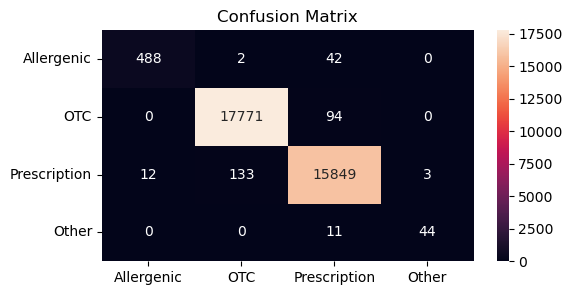

In [130]:
plt.figure(figsize=(6, 3))
ax = sns.heatmap(cf_l2, annot=True, fmt="d", 
                 xticklabels=["Allergenic", "OTC", "Prescription", 'Other'], 
                 yticklabels=["Allergenic", "OTC", "Prescription", 'Other'])
ax.set(title="Confusion Matrix");

## KNN

We will use Grid Search CV to detemine the number of nearest neighbors needed for the best fit. 

### Grid search CV to identify correct value of K

In [131]:
knn = KNeighborsClassifier()
params_grid = {
    'n_neighbors': [3,5,7,9,11]
}

In [132]:
search_knn = GridSearchCV(estimator = knn, 
                        param_grid = params_grid, 
                        scoring='accuracy',
                        cv = 5, verbose = 1)

In [164]:
#search_knn.fit(X_train, y_train.values.ravel())

In [130]:
best_params = search_knn.best_params_
print('Best_params from GridSearchCV : {}'.format(best_params))

Best_params from GridSearchCV : {'n_neighbors': 3}


### Error Metrics with K=3

In [131]:
#knn=search_knn.best_estimator_
#knn.fit(X_train,y_train)

knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train,y_train)

KNeighborsClassifier(n_neighbors=3)

In [132]:
y_pr_knn3=knn.predict(X_test)

In [133]:
#print("Classification Report with nearest neighbors, K=5")
#print("-------------------------------------------------")
#print(classification_report(y_test, y_pr_knn3))

In [134]:
cr_knn3=get_classification_report_df(y_test, y_pr_knn3)
cr_knn3

,precision,recall,f1-score,support
0,0.985887,0.919173,0.951362,532.000000
1,0.994678,0.993955,0.994316,17865.000000
2,0.990032,0.993436,0.991731,15997.000000
3,0.918367,0.818182,0.865385,55.000000
accuracy,0.992278,0.992278,0.992278,0.992278
macro avg,0.972241,0.931186,0.950699,34449.000000
weighted avg,0.992263,0.992278,0.992247,34449.000000


In [135]:
#cr_knn3.T.accuracy[0]

In [136]:
get_accuracy(X_train, X_test, y_train, y_test, knn)

{'test Accuracy': 0.9922784405933409, 'train Accuracy': 0.9953967503545746}

### Confusion Matrix

In [137]:
cf_knn3 = confusion_matrix(y_test,y_pr_knn3)

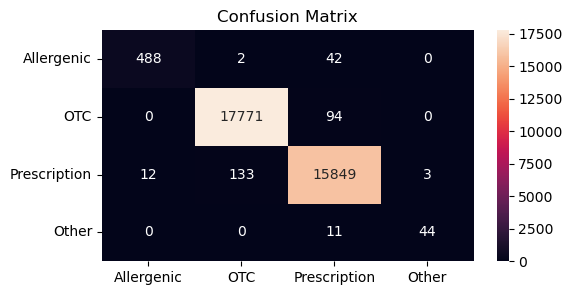

In [138]:
plt.figure(figsize=(6, 3))
ax = sns.heatmap(cf_l2, annot=True, fmt="d", 
                 xticklabels=["Allergenic", "OTC", "Prescription", 'Other'], 
                 yticklabels=["Allergenic", "OTC", "Prescription", 'Other'])
ax.set(title="Confusion Matrix");

## Decision Tree (w/wo Bagging)

### Decision Tree (basic)

Here we will look at a vanilla decision tree model (without bagging). We will implement cross validation method via GridSearchCV to determine the best hyperparameters for our fit. 

In [135]:
def plot_decision_tree(model, feature_names):
    plt.subplots(figsize=(25, 20)) 
    tree.plot_tree(model, 
                       feature_names=None,  
                       filled=True)
    plt.show()

**Cross validation (CV) & hyperparameter tuning**

In [136]:
params_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [5, 10, 15, 20, 25],
    'min_samples_leaf': [1, 2, 5]
}

In [137]:
dt = DecisionTreeClassifier(random_state=42)
dt = dt.fit(X_train, y_train.values.ravel())

In [138]:
search_dt = GridSearchCV(estimator = dt, 
                            param_grid = params_grid, 
                            scoring='f1_weighted',
                            cv = 5, verbose = 1)

search_dt.fit(X_train, y_train.values.ravel())

best_params = search_dt.best_params_

Fitting 5 folds for each of 30 candidates, totalling 150 fits


In [139]:
best_params

{'criterion': 'entropy', 'max_depth': 20, 'min_samples_leaf': 1}

In [141]:
search_dt.best_estimator_

DecisionTreeClassifier(criterion='entropy', max_depth=20, random_state=42)

**Fit with best parameters from CV**

In [142]:
DT = search_dt.best_estimator_

DT.fit(X_train,y_train.values.ravel())

DecisionTreeClassifier(criterion='entropy', max_depth=20, random_state=42)

In [147]:
y_train_pr=DT.predict(X_train)
y_pr_dt_best=DT.predict(X_test)

In [148]:
#cr_dt_train=get_classification_report_df(y_train, y_train_pr)
#cr_dt_train

**Plot Decision Tree**

In [149]:
feature_names = X_train.columns.values

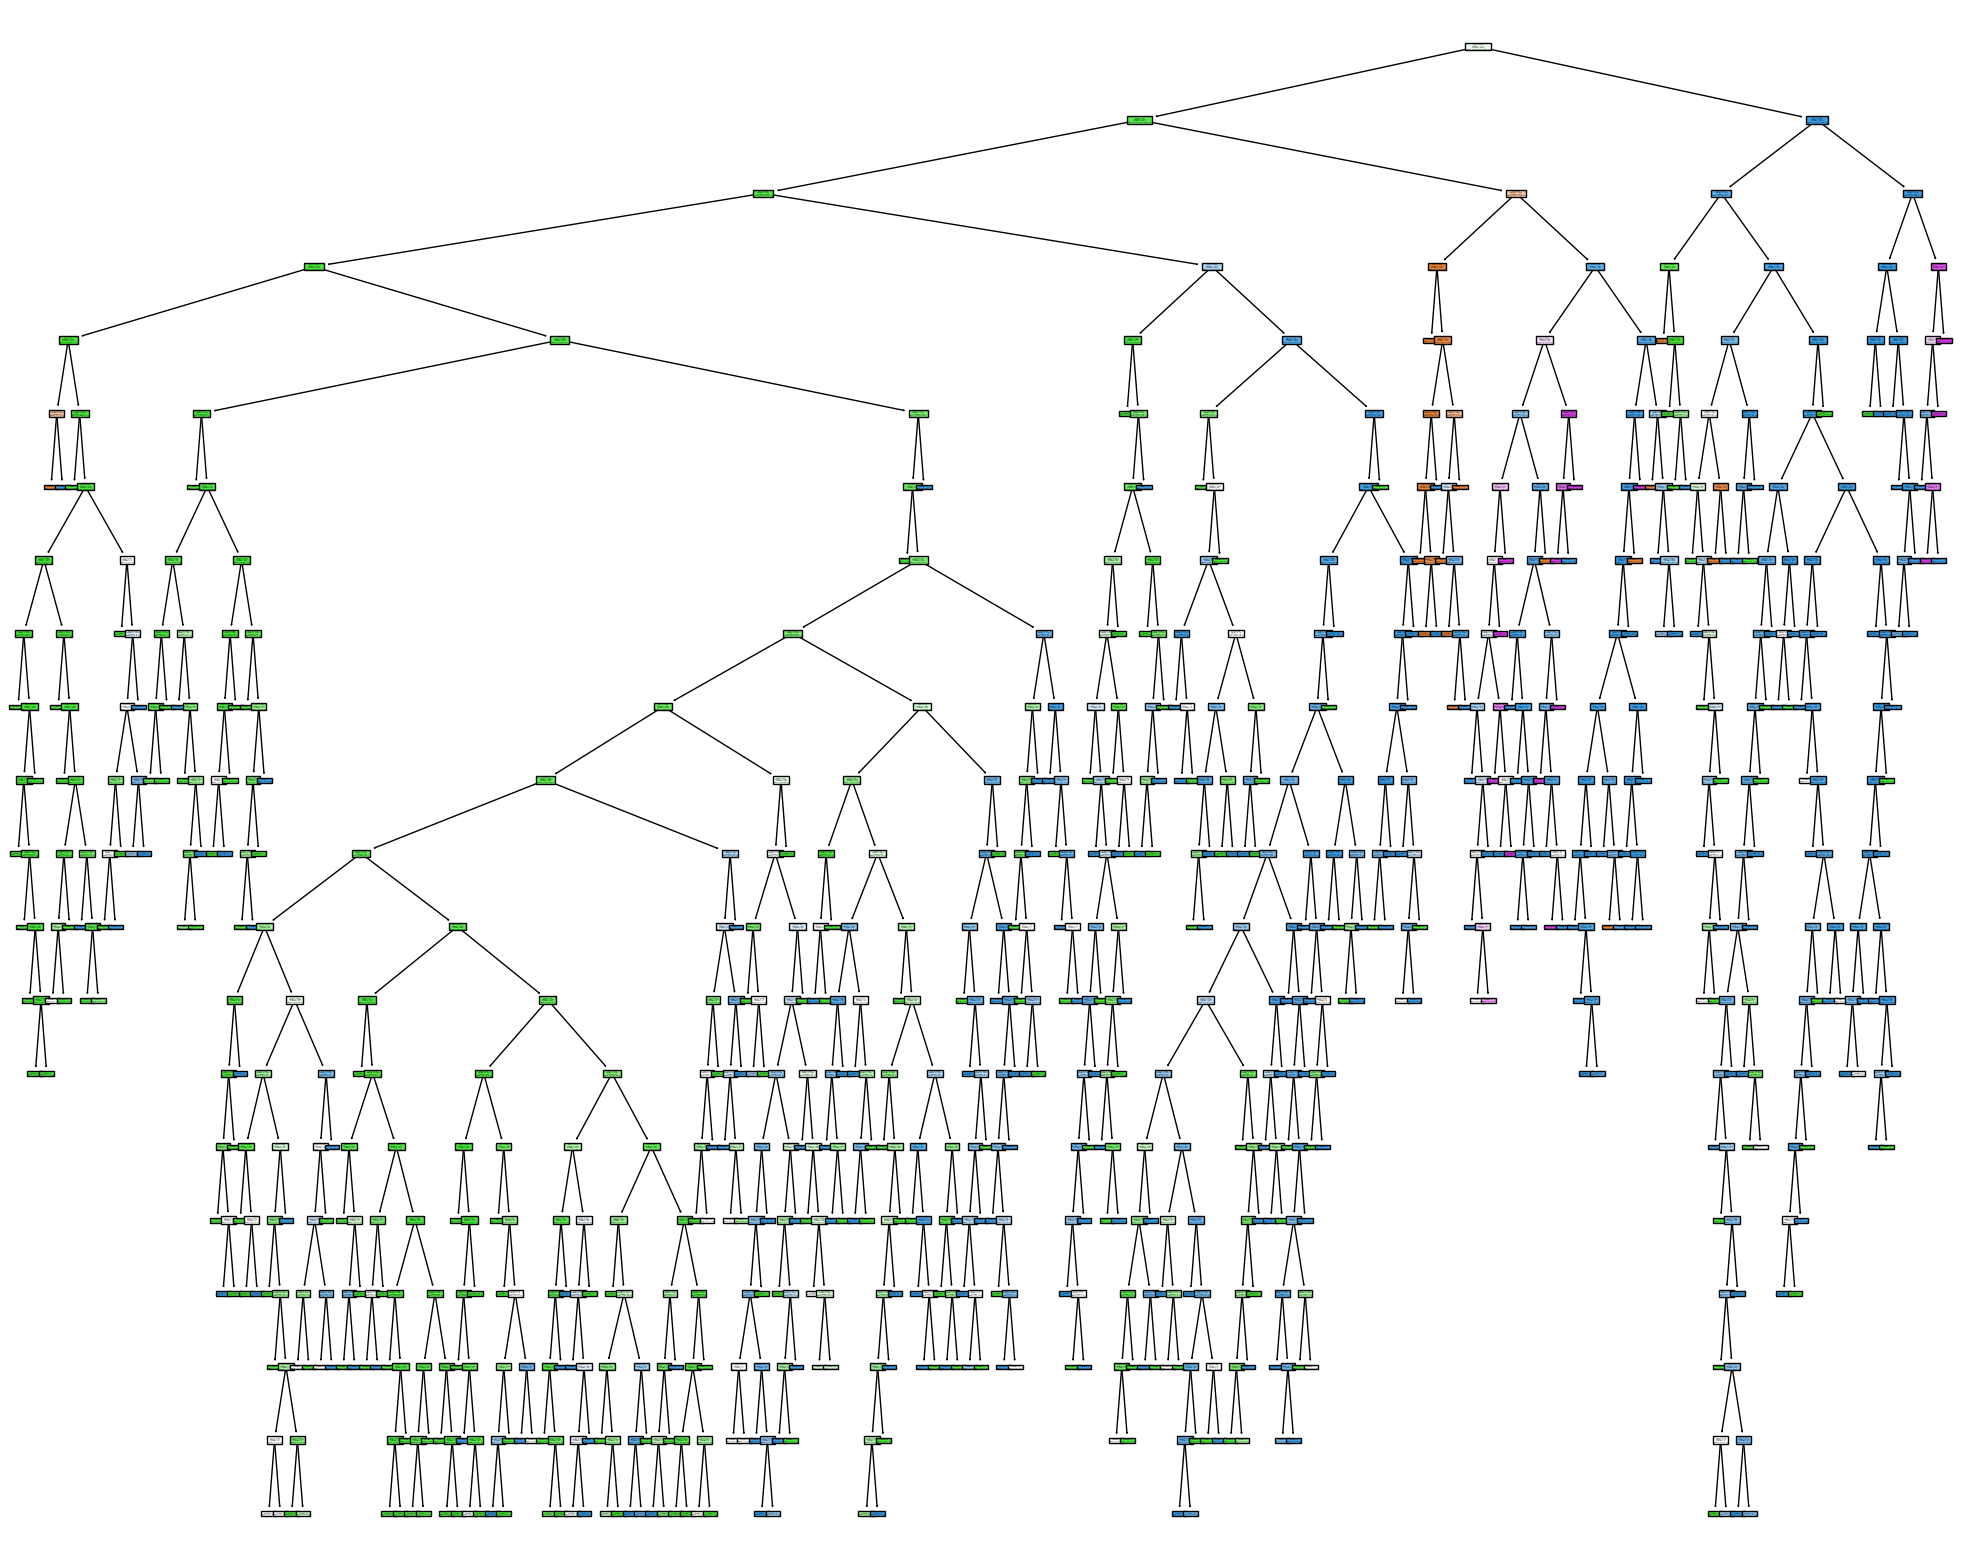

In [150]:
plot_decision_tree(model=DT,feature_names=feature_names)

#### Error Metrics

In [151]:
cr_dt=get_classification_report_df(y_test, y_pr_dt_best)
cr_dt

,precision,recall,f1-score,support
0,0.991952,0.926692,0.958212,532.000000
1,0.993742,0.995522,0.994631,17865.000000
2,0.992252,0.992749,0.992500,15997.000000
3,0.960000,0.872727,0.914286,55.000000
accuracy,0.992975,0.992975,0.992975,0.992975
macro avg,0.984487,0.946922,0.964907,34449.000000
weighted avg,0.992969,0.992975,0.992951,34449.000000


In [152]:
get_accuracy(X_train, X_test, y_train, y_test, DT)

{'test Accuracy': 0.9929751226450695, 'train Accuracy': 0.9975117569484188}

#### Confusion Matrix

In [153]:
cf_dt = confusion_matrix(y_test,y_pr_dt_best)

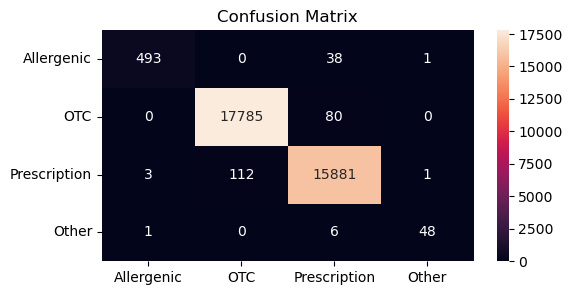

In [154]:
plt.figure(figsize=(6, 3))
ax = sns.heatmap(cf_dt, annot=True, fmt="d", 
                 xticklabels=["Allergenic", "OTC", "Prescription", 'Other'], 
                 yticklabels=["Allergenic", "OTC", "Prescription", 'Other'])
ax.set(title="Confusion Matrix");

### Decision Tree with Bagging

Here we will implement "bagging" or bootstrap resampling of our ensembles (rows/data) to see if we can reduce the effect of overfitting. A higher accuracy score for the test sample (compared to the case without bagging) will imply less overfitting.

**Grid search CV**

As before, we will choose grid search CV to tune the hyperparameters. 

In [155]:
param_grid = {'n_estimators': [2*n+1 for n in range(10)],
              'base_estimator__max_depth' : [2*n+1 for n in range(10) ] }

In [159]:
search_bag = GridSearchCV(estimator=BaggingClassifier(base_estimator=dt,
                            random_state=42,
                            bootstrap=True), 
                            param_grid=param_grid, scoring='accuracy', cv=3)

In [165]:
search_bag.fit(X_train,y_train)

GridSearchCV(cv=3,
             estimator=BaggingClassifier(base_estimator=DecisionTreeClassifier(random_state=42),
                                         random_state=42),
             param_grid={'base_estimator__max_depth': [1, 3, 5, 7, 9, 11, 13,
                                                       15, 17, 19],
                         'n_estimators': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19]},
             scoring='accuracy')

In [166]:
search_bag.best_params_

{'base_estimator__max_depth': 19, 'n_estimators': 9}

In [167]:
search_bag.best_score_

0.9941526309939746

In [168]:
Bag = search_bag.best_estimator_
Bag.fit(X_train, y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=19,
                                                        random_state=42),
                  n_estimators=9, random_state=42)

In [169]:
ytest_pr_bag = Bag.predict(X_test)
ytrain_pr_bag = Bag.predict(X_train)

#### Error Metrics

In [170]:
cr_dt_bag = get_classification_report_df(y_test, ytest_pr_bag)
cr_dt_bag

,precision,recall,f1-score,support
0,0.993952,0.926692,0.959144,532.000000
1,0.994692,0.996418,0.995554,17865.000000
2,0.993188,0.993436,0.993312,15997.000000
3,0.875000,0.890909,0.882883,55.000000
accuracy,0.993788,0.993788,0.993788,0.993788
macro avg,0.964208,0.951864,0.957723,34449.000000
weighted avg,0.993791,0.993788,0.993771,34449.000000


In [171]:
get_accuracy(X_train, X_test, y_train, y_test, Bag)

{'test Accuracy': 0.9937879183720862, 'train Accuracy': 0.9974246684416134}

#### n_estimator correlations

In [172]:
corr = get_correlation(X_test, y_test,Bag)

#corr.mean().mean()-1/n_estimators
#corr = get_correlation(X_test, y_test,RF)
corr.mean(), corr.mean().mean(), 1/9, corr.mean().mean()-1/9, 

#corr.mean() --> average correlation for each estimator
#corr.mean().mean() --> average from all estimators
#corr.mean().mean() - 1/n_est --> Final average

Average correlation between predictors:  0.8797462596761809


(estimator 1    0.991780
 estimator 2    0.990516
 estimator 3    0.990947
 estimator 4    0.990903
 estimator 5    0.990558
 estimator 6    0.990627
 estimator 7    0.991110
 estimator 8    0.990619
 estimator 9    0.990655
 dtype: float64,
 0.9908573707872921,
 0.1111111111111111,
 0.8797462596761809)

In [173]:
get_correlation(X_test, y_test,Bag).style.background_gradient(cmap='coolwarm')

Average correlation between predictors:  0.8797462596761809


,estimator 1,estimator 2,estimator 3,estimator 4,estimator 5,estimator 6,estimator 7,estimator 8,estimator 9
estimator 1,1.000000,0.990558,0.991439,0.991441,0.990464,0.990819,0.991174,0.989565,0.990560
estimator 2,0.990558,1.000000,0.989369,0.989268,0.988602,0.987921,0.990453,0.989674,0.988802
estimator 3,0.991439,0.989369,1.000000,0.990148,0.988859,0.988801,0.991022,0.989724,0.989163
estimator 4,0.991441,0.989268,0.990148,1.000000,0.989070,0.989425,0.989883,0.989416,0.989477
estimator 5,0.990464,0.988602,0.988859,0.989070,1.000000,0.989279,0.988802,0.989890,0.990053
estimator 6,0.990819,0.987921,0.988801,0.989425,0.989279,1.000000,0.989676,0.989832,0.989893
estimator 7,0.991174,0.990453,0.991022,0.989883,0.988802,0.989676,1.000000,0.989251,0.989728
estimator 8,0.989565,0.989674,0.989724,0.989416,0.989890,0.989832,0.989251,1.000000,0.988222
estimator 9,0.990560,0.988802,0.989163,0.989477,0.990053,0.989893,0.989728,0.988222,1.000000


As is evident above, the correlations between the predictors is very high ~0.88. One way to reduce the correlations between the predictors is by implementing 'Random Forest'. This methods draws our the features of our dataset at random (along with bootstra selection of the data/rows) for each ensemble. 

## Random Forest

In [174]:
RF = RandomForestClassifier()
RF.get_params().keys()

dict_keys(['bootstrap', 'ccp_alpha', 'class_weight', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'max_samples', 'min_impurity_decrease', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_jobs', 'oob_score', 'random_state', 'verbose', 'warm_start'])

**Grid search/CV**

In [175]:
param_grid={'n_estimators': [2*n+1 for n in range(10)],
            'max_depth' : [2*n+1 for n in range(10) ],
            'max_features' : ['sqrt', 'log2']
           }

In [176]:
search_rf=GridSearchCV(estimator = RF, 
                       param_grid=param_grid,
                       scoring='accuracy')

In [177]:
search_rf.fit(X_train,y_train)

GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'max_depth': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19],
                         'max_features': ['sqrt', 'log2'],
                         'n_estimators': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19]},
             scoring='accuracy')

In [178]:
search_rf.best_params_

{'max_depth': 19, 'max_features': 'sqrt', 'n_estimators': 19}

In [180]:
get_accuracy(X_train, X_test, y_train, y_test, search_rf)

{'test Accuracy': 0.9938750036285523, 'train Accuracy': 0.997213167782229}

In [181]:
search_rf.best_score_

0.9947746981000435

In [182]:
RF = RandomForestClassifier(max_depth=19,
                           max_features='sqrt',
                           n_estimators=19,
                           random_state=42)
RF

RandomForestClassifier(max_depth=19, n_estimators=19, random_state=42)

In [183]:
RF.fit(X_train,y_train)

RandomForestClassifier(max_depth=19, n_estimators=19, random_state=42)

In [184]:
y_pr_rf = RF.predict(X_test)
ytrain_pr_rf = RF.predict(X_train)

#### Error Metrics

In [185]:
cr_dt_rf = get_classification_report_df(y_test, y_pr_rf)
cr_dt_rf

,precision,recall,f1-score,support
0,0.993939,0.924812,0.958130,532.000000
1,0.994693,0.996641,0.995666,17865.000000
2,0.993252,0.993686,0.993469,15997.000000
3,0.920000,0.836364,0.876190,55.000000
accuracy,0.993904,0.993904,0.993904,0.993904
macro avg,0.975471,0.937876,0.955864,34449.000000
weighted avg,0.993893,0.993904,0.993875,34449.000000


#### Confusion Matrix

In [186]:
cf_rf = confusion_matrix(y_test,y_pr_rf)

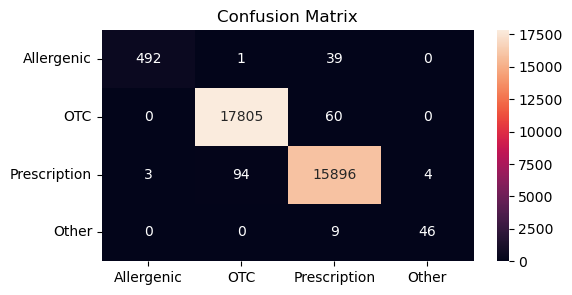

In [187]:
plt.figure(figsize=(6, 3))
ax = sns.heatmap(cf_rf, annot=True, fmt="d", 
                 xticklabels=["Allergenic", "OTC", "Prescription", 'Other'], 
                 yticklabels=["Allergenic", "OTC", "Prescription", 'Other'])
ax.set(title="Confusion Matrix");

#### n_estimator correlations

Correlations for **n_estimators = 19**

In [188]:
get_correlation(X_test, y_test,RF).style.background_gradient(cmap='coolwarm')

Average correlation between predictors:  0.9338075760458466


,estimator 1,estimator 2,estimator 3,estimator 4,estimator 5,estimator 6,estimator 7,estimator 8,estimator 9,estimator 10,estimator 11,estimator 12,estimator 13,estimator 14,estimator 15,estimator 16,estimator 17,estimator 18,estimator 19
estimator 1,1.000000,0.986342,0.986499,0.986043,0.985467,0.984892,0.988269,0.986552,0.986509,0.988368,0.986806,0.984420,0.988052,0.986823,0.986410,0.986290,0.988725,0.988106,0.986232
estimator 2,0.986342,1.000000,0.986964,0.985264,0.986038,0.984837,0.985933,0.984734,0.986248,0.985927,0.985089,0.985510,0.986128,0.986250,0.984489,0.984158,0.986801,0.985974,0.985243
estimator 3,0.986499,0.986964,1.000000,0.984798,0.987128,0.987072,0.987543,0.983748,0.985367,0.987226,0.987117,0.985459,0.986182,0.987342,0.984231,0.986186,0.986854,0.985612,0.984050
estimator 4,0.986043,0.985264,0.984798,1.000000,0.984490,0.983710,0.986253,0.983707,0.986571,0.985730,0.987075,0.982613,0.984687,0.984398,0.985849,0.984485,0.985773,0.985365,0.984011
estimator 5,0.985467,0.986038,0.987128,0.984490,1.000000,0.985831,0.986608,0.983542,0.984853,0.987332,0.985874,0.986394,0.986186,0.986415,0.984132,0.984635,0.987169,0.984683,0.983951
estimator 6,0.984892,0.984837,0.987072,0.983710,0.985831,1.000000,0.985831,0.983594,0.983760,0.986137,0.985716,0.986032,0.986339,0.984594,0.983559,0.986136,0.984829,0.984315,0.984312
estimator 7,0.988269,0.985933,0.987543,0.986253,0.986608,0.985831,1.000000,0.984891,0.985786,0.989720,0.986912,0.987224,0.986289,0.987141,0.984961,0.986919,0.987168,0.985410,0.984573
estimator 8,0.986552,0.984734,0.983748,0.983707,0.983542,0.983594,0.984891,1.000000,0.985211,0.985926,0.982701,0.982910,0.985714,0.985735,0.983141,0.983331,0.986489,0.986288,0.983166
estimator 9,0.986509,0.986248,0.985367,0.986571,0.984853,0.983760,0.985786,0.985211,1.000000,0.986404,0.985257,0.984741,0.986814,0.986210,0.985382,0.985781,0.985824,0.986349,0.986034
estimator 10,0.988368,0.985927,0.987226,0.985730,0.987332,0.986137,0.989720,0.985926,0.986404,1.000000,0.987220,0.986598,0.987635,0.986927,0.984333,0.985147,0.989243,0.986962,0.986231


Interestingly, we find that the average correlations between the estimators is very high with a value of 0.93! 
This average correlation was computed for n_estimators = 19. In order to compare the average correlation with bagging, we need to ensure that the hhyperparameters for the two models are the same. The best fit for bagging resulted in n_estimators = 9. Therefore, we will re-run our RF model with n_estimators=9.

**n_estimators=9**

In [189]:
RF9 = RandomForestClassifier(max_depth=19,
                           max_features='sqrt',
                           n_estimators=9,
                           random_state=42)

In [190]:
RF9.fit(X_train, y_train)

RandomForestClassifier(max_depth=19, n_estimators=9, random_state=42)

In [191]:
y_pr_rf_nes9 = RF9.predict(X_test)

In [192]:
get_correlation(X_test, y_test,RF9).style.background_gradient(cmap='coolwarm')

Average correlation between predictors:  0.8760712449300747


,estimator 1,estimator 2,estimator 3,estimator 4,estimator 5,estimator 6,estimator 7,estimator 8,estimator 9
estimator 1,1.000000,0.986342,0.986499,0.986043,0.985467,0.984892,0.988269,0.986552,0.986509
estimator 2,0.986342,1.000000,0.986964,0.985264,0.986038,0.984837,0.985933,0.984734,0.986248
estimator 3,0.986499,0.986964,1.000000,0.984798,0.987128,0.987072,0.987543,0.983748,0.985367
estimator 4,0.986043,0.985264,0.984798,1.000000,0.984490,0.983710,0.986253,0.983707,0.986571
estimator 5,0.985467,0.986038,0.987128,0.984490,1.000000,0.985831,0.986608,0.983542,0.984853
estimator 6,0.984892,0.984837,0.987072,0.983710,0.985831,1.000000,0.985831,0.983594,0.983760
estimator 7,0.988269,0.985933,0.987543,0.986253,0.986608,0.985831,1.000000,0.984891,0.985786
estimator 8,0.986552,0.984734,0.983748,0.983707,0.983542,0.983594,0.984891,1.000000,0.985211
estimator 9,0.986509,0.986248,0.985367,0.986571,0.984853,0.983760,0.985786,0.985211,1.000000


The **average correlations between estimators did not change significantly between Bagging and Random Forest.**

#### Feature Importance

In [194]:
sel_rf = SelectFromModel(RandomForestClassifier(max_depth=19,
                                            max_features='sqrt',
                                            n_estimators=19,
                                            random_state=42))
sel_rf.fit(X_train, y_train)


SelectFromModel(estimator=RandomForestClassifier(max_depth=19, n_estimators=19,
                                                 random_state=42))

In [195]:
#sel_rf.get_support()

In [196]:
selected_feat= X_train.columns[(sel_rf.get_support())]
len(selected_feat)

6

In [197]:
selected_feat

Index(['Propriety Name', 'Doseage Form Name_1', 'Labeler Name',
       'Substance Name', 'Route Name_TOPICAL etc', 'Marketing Name_ANDA'],
      dtype='object')

# Comparison of Error Metrics

In [198]:
def get_error_comparison(X_train, X_test, y_train, y_test):
    
    
    from warnings import simplefilter
    simplefilter(action='ignore', category=FutureWarning)


    Test_Accuracy = []
    Train_Accuracy = []

    #test = [DT, Bag]
    
    model = [LogReg_l2, LogReg_l1, #knn, 
             DT, Bag, RF]

    for mod in model:
        
        Test_Accuracy.append(metrics.accuracy_score(y_test, mod.predict(X_test)))
        Train_Accuracy.append(metrics.accuracy_score(y_train, mod.predict(X_train)))
        
    test_acc = pd.Series(data=Test_Accuracy, 
                         index=['Logistic Reg with L2',
                                'Logistic Reg with L1',
                                #'KNN, n=3',
                                'Decision Tree (Basic)', 
                                'Decision Tree (Bagged)',
                                'Random Forest'],
                         dtype='float64')
    
    train_acc = pd.Series(data=Train_Accuracy, 
                         index=['Logistic Reg with L2',
                                'Logistic Reg with L1',
                                #'KNN, n=3',
                                'Decision Tree (Basic)', 
                                'Decision Tree (Bagged)',
                                'Random Forest'],
                         dtype='float64')
        
    d = {'Train_accuracy':train_acc, 'Test_accuracy': test_acc}

    error_comp_df = pd.DataFrame(data=d)
        
    return error_comp_df

In [199]:
error_comparison_df = get_error_comparison(X_train, X_test, y_train, y_test)

One way to compare the quality of classification between each of these models is too look at the classification accuracy.

In [200]:
error_comparison_df

,Train_accuracy,Test_accuracy
Logistic Reg with L2,0.992237,0.991379
Logistic Reg with L1,0.992336,0.991669
Decision Tree (Basic),0.997512,0.992975
Decision Tree (Bagged),0.997425,0.993788
Random Forest,0.997325,0.993904


**Observations:**

1) The difference between the train and test accuracy across all models is very small. This implies the **absence of overfitting** in all of our models. 

2) The accuracy (both in training data and test) is the highest for Random Forest.  

# Summary

Our goal in this project was drug classification- to categorize each drug into OTC (over the counter), Precription drug, Allergenic Drugs or Other miscelaneous drugs. All the features in this dataset were catergorical. We performed EDA (exploratory data analysis) to clean up the data (handle null values, drop unnecessary rows and/or features, choose features of relevance etc..). We then performed feature engineering to modify the features to better to tackle features with large cardinality (very large unique values). Feature encoding was then implemented to convert all our categorical features into numeric ones. Finally, 6 different classification algorithms, namely Logistic regression with L2 regularization, Logistic regression with L1 regularization, K-nearest neighbours with n=3 nearest neghbors, Decision Tree models (with and wihtout bagging) and Random Forest. 

Hyperparameter tuning (HPT) and cross validation (CV) for four of the models, namely KNN, Decision Trees (w and w/o bagging) and Random Forest, were performed via GridSearchCV method and the parameters from the best fit were implement. Two different scoring methods, accuracy for KNN and Random Forsr and f1-weighted for Decision Tree, were implement during grid search (CV and HPT). 

The classification with Random Forest model was observed to have to highest test accuracy (lowest test error). The difference between the train and test error was found to be very small across all models indicating the absence of overfitting. (In the model that is overfit, the test accuracy is usually significantly lower than train accuracy. We do not see this in any of our classification models). 

# Scope

There are many more feature encoding methods that one can implement for features with large cardinalities. It will be interesting to investigate further how the various feature encoding methods for features with large cardinality might affect the prediction. 

We perhaps improve our predictions by applying more complex meachine learning algorithms like deep learning (?). 